## 深入了解CNN

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from datetime import timedelta

In [3]:
tf.__version__

'1.1.0'

### 导入数据

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('mnist_data/', one_hot=True)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


将标签提出出来

In [5]:
mnist.test.cls = np.argmax(mnist.test.labels, axis=1)

In [6]:
mnist.test.cls[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

### 配置参数

In [7]:
img_size = 28 # 图片长/宽
img_size_flat = img_size * img_size # 扁平图片大小
img_shape = (img_size, img_size) # 图片尺寸
num_channels = 1 
num_classes = 10

### 搭建模型

![](images/cnn_model.png)

生成变量函数

In [8]:
def weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))


def bias(shape):
    return tf.Variable(tf.constant(0.05, shape=shape))

卷积函数 + 全连接函数

In [9]:
def conv_layer(images, filter_size, in_channels, out_channels, use_pooling=True):
    """卷积+max pool函数
    
    parameters
    ---
    filter_size : int
        conv2d的filter宽，高
    in_channels : int
        输入images的channels
    out_channels : int
        输出images的channels
    """
    shape = [filter_size, filter_size, in_channels, out_channels]
    _filter = weights(shape)
    _bias = bias([out_channels])
    
    layer = tf.nn.conv2d(images, _filter, strides=[1, 1, 1, 1], padding='SAME') + _bias
    layer = tf.nn.relu(layer)    
    
    if use_pooling:
         layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')   
    
    return layer, _filter

In [10]:
def flatten_layer(layer):
    """flatten features"""
    layer_shape = layer.get_shape()
    # 计算width * height * channels
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, shape=[-1, num_features])
    return layer_flat, num_features

In [11]:
def fc_layer(layer, num_inputs, num_outputs, use_relu=True):
    """全连接网络
    
    parameters
    ---
    num_inputs  : int
        输入layer的特征数
    num_outputs : int
        输出layer的特征数
    """
    W = weights([num_inputs, num_outputs])
    b = bias([num_outputs])
    
    fc_layer = tf.matmul(layer, W) + b
    if use_relu:
        fc_layer = tf.nn.relu(fc_layer)
    return fc_layer

#### 终于开始搭建模型了

In [12]:
x = tf.placeholder(dtype=tf.float32, shape=[None, img_size_flat])
x_images = tf.reshape(x, shape=[-1, img_size, img_size, num_channels])
y_true = tf.placeholder(dtype=tf.float32, shape=[None, 10])
y_true_cls = tf.argmax(y_true, axis=1)

In [13]:
# 第一层卷积
layer_conv1, weights_conv1 = conv_layer(x_images, 
                                        filter_size=5, in_channels=1, out_channels=16)
layer_conv1

<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 16) dtype=float32>

In [14]:
# 第二层卷积
layer_conv2, weights_conv2 = conv_layer(layer_conv1, 
                                       filter_size=5, in_channels=16, out_channels=36)
layer_conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [15]:
layer_flat, num_features = flatten_layer(layer_conv2)
print('layer_flat', layer_flat)
print(num_features)

layer_flat Tensor("Reshape_1:0", shape=(?, 1764), dtype=float32)
1764


In [16]:
# fc咯
fc_layer1 = fc_layer(layer_flat, num_features, 128)
fc_layer1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [17]:
fc_layer2 = fc_layer(fc_layer1, 128, 10)
fc_layer2

<tf.Tensor 'Relu_3:0' shape=(?, 10) dtype=float32>

虽然最后的FC输出已经是我们的num_classes了，当时这些数字输出可能大，可能小（方差大），**毫无解释性**。我们需要将它normalize一下，这里使用softmax，它会固定输出再0到1之内，这也符合了我们要使用的概率挑选。

In [18]:
y_pred = tf.nn.softmax(fc_layer2)
y_pred_cls = tf.argmax(y_pred, axis=1)

#### cost fucntion

In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=fc_layer2)
loss = tf.reduce_mean(cross_entropy)

#### optimizer

In [20]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

#### performance measures

In [21]:
correct_prediction = tf.equal(y_pred_cls, y_pred_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

#### Run  = =

In [22]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [23]:
total_iterations = 0

def optimize(num_iterations, batch_size=100):
    global total_iterations
    
    start_time = time.time()
    
    for step in range(total_iterations, total_iterations + num_iterations):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {x: batch_xs, y_true: batch_ys}
        sess.run(optimizer, feed_dict)
        
        if step % 100 == 0:
            acc = accuracy.eval(feed_dict)
            msg = 'Optimization Iterations: {0:>6}, Traing Accuracy: {1:>6.1%}'
            print(msg.format(step + 1, acc))
            
    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print('Time Usage: ' + str(timedelta(seconds=int(round(time_dif)))))

### 配置一些有用的函数

In [24]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap=plt.cm.binary)
        if cls_pred is None:
            ax.set_title('True:{0}'.format(cls_true[i]))
        else:
            ax.set_title('True:{0},Pred:{1}'.format(cls_true[i], cls_pred[i]))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [25]:
def plot_example_error(cls_pred, correct):
    
    incorrect = (correct == False)
    
    images = mnist.test.images[incorrect][0:9]
    cls_pred = cls_pred[incorrect][0:9]
    cls_true = mnist.test.cls[incorrect][0:9]
    
    plot_images(images, cls_true, cls_pred)

In [26]:
def plot_confusion_matrix(cls_pred):
    
    from sklearn.metrics import confusion_matrix
    
    cls_true = mnist.test.cls
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    print(cm)
    
    plt.matshow(cm)
    plt.colorbar()
    ticks_marks = np.arange(num_classes)
    plt.xticks(ticks_marks, range(num_classes))
    plt.yticks(ticks_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [27]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    
    num_test = len(mnist.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = mnist.test.images[i:j, :]
        labels = mnist.test.labels[i:j, :]
        feed_dict = {x: images, 
                     y_true: labels}
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    
    cls_true = mnist.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = sum(correct)
    acc = correct_sum / num_test
    msg = 'Accuracy on Test_Set: {0:.1%}({1}/{2})'
    print(msg.format(acc, correct_sum, num_test))
    
    if show_example_errors:
        print('Example Error:')
        plot_example_error(cls_pred=cls_pred, correct=correct)
    if show_confusion_matrix:
        print('Confusion Matrix:')
        plot_confusion_matrix(cls_pred=cls_pred)

### 好好见证CNN的训练

还没有开始训练

In [28]:
print_test_accuracy()

Accuracy on Test_Set: 14.2%(1424/10000)


仅仅迭代一次

In [29]:
optimize(num_iterations=1)

Optimization Iterations:      1, Traing Accuracy: 100.0%
Time Usage: 0:00:00


In [30]:
print_test_accuracy()

Accuracy on Test_Set: 14.0%(1401/10000)


来100次迭代

In [31]:
optimize(num_iterations=99)

Time Usage: 0:00:02


Accuracy on Test_Set: 55.4%(5539/10000)
Example Error:


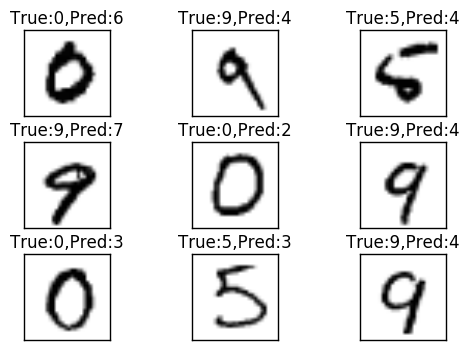

In [32]:
print_test_accuracy(show_example_errors=True)

再来1000次迭代

In [33]:
optimize(num_iterations=900)

Optimization Iterations:    101, Traing Accuracy: 100.0%
Optimization Iterations:    201, Traing Accuracy: 100.0%
Optimization Iterations:    301, Traing Accuracy: 100.0%
Optimization Iterations:    401, Traing Accuracy: 100.0%
Optimization Iterations:    501, Traing Accuracy: 100.0%
Optimization Iterations:    601, Traing Accuracy: 100.0%
Optimization Iterations:    701, Traing Accuracy: 100.0%
Optimization Iterations:    801, Traing Accuracy: 100.0%
Optimization Iterations:    901, Traing Accuracy: 100.0%
Time Usage: 0:00:23


Accuracy on Test_Set: 76.4%(7638/10000)
Example Error:


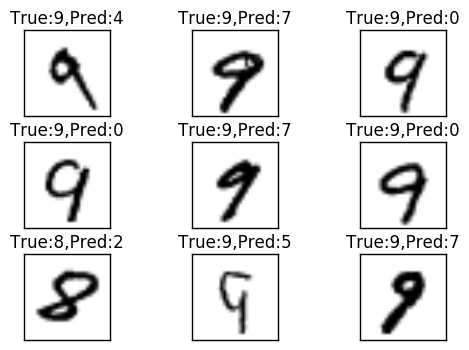

In [ ]:
print_test_accuracy(show_example_errors=True)

直接10,000次迭代

In [ ]:
optimize(num_iterations=9000)

Optimization Iterations:   1001, Traing Accuracy: 100.0%
Optimization Iterations:   1101, Traing Accuracy: 100.0%
Optimization Iterations:   1201, Traing Accuracy: 100.0%
Optimization Iterations:   1301, Traing Accuracy: 100.0%
Optimization Iterations:   1401, Traing Accuracy: 100.0%
Optimization Iterations:   1501, Traing Accuracy: 100.0%
Optimization Iterations:   1601, Traing Accuracy: 100.0%
Optimization Iterations:   1701, Traing Accuracy: 100.0%
Optimization Iterations:   1801, Traing Accuracy: 100.0%
Optimization Iterations:   1901, Traing Accuracy: 100.0%
Optimization Iterations:   2001, Traing Accuracy: 100.0%
Optimization Iterations:   2101, Traing Accuracy: 100.0%
Optimization Iterations:   2201, Traing Accuracy: 100.0%
Optimization Iterations:   2301, Traing Accuracy: 100.0%
Optimization Iterations:   2401, Traing Accuracy: 100.0%
Optimization Iterations:   2501, Traing Accuracy: 100.0%
Optimization Iterations:   2601, Traing Accuracy: 100.0%
Optimization Iterations:   2701

In [ ]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)